#  Deep Neural Network (DNN) 

### Regularization of DNN [256,256,256,256] with l2 regularization

##  Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time
from functools import partial

%store -r
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.7957011
X_32train_std             -> array([[-0.44445615,  0.62874736, -0.19049071, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[-0.004097
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.8784659
X_train                   -> array([[[-0.00304779,  0.0030504 , -0.00249425, ..
X_train_std               -> array([[-0.44445615,  0.62874736, -0.19049071, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {0: array([6, 7, 1, ..
y_32_train                -> array([7, 2, 4, ..., 5, 5, 3])
y_test                    -> defaultdict(<class 'list'>, {0: array([3, 2, 5, ..
y_train                   -> array([7, 2, 4, ..., 5, 5, 3])


In [2]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
# tf.reset_default_graph()

## Create validation set required for early stopping

In [4]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)

for snr in snrs:
    n_test = X_32test_std[snr].shape[0]
    X_val.append(X_32test_std[snr][:(n_test*0.5)])
    y_val.append(y_32_test[snr][:(n_test*0.5)])
    X_test_new[snr] = X_32test_std[snr][(n_test*0.5):]
    y_test_new[snr] = y_32_test[snr][(n_test*0.5):]
    
X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))

print("Validation set data", X_val.shape, "and labels", y_val.shape)

X_32test_std = X_test_new
y_32_test = y_test_new
X_32_val = X_val 
y_32_val = y_val

Validation set data (40000, 32) and labels (40000,)


##  Design and train the DNN

In [5]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 256
n_hidden2 = 256
n_hidden3 = 256
n_hidden4 = 256

n_outputs = 8

X = tf.placeholder(tf.float32, shape=(None, 32))
y = tf.placeholder(tf.int64, shape=(None))
training_ = tf.placeholder_with_default(False, shape=[])

weight_init = tf.contrib.layers.xavier_initializer()
activation_func = tf.nn.elu

# ------------------- Define layers -----------------------

from tensorflow.contrib.layers import fully_connected

scale_val = 0.001
new_dense_layer = partial(tf.layers.dense, kernel_initializer = weight_init,
                          kernel_regularizer = tf.contrib.layers.l2_regularizer(scale_val), 
                          activation = activation_func)

dense_layer1 = new_dense_layer(X, n_hidden1)

dense_layer2 = new_dense_layer(dense_layer1, n_hidden2)

dense_layer3 = new_dense_layer(dense_layer2, n_hidden3)

dense_layer4 = new_dense_layer(dense_layer3, n_hidden4)

logits = tf.layers.dense(dense_layer4, n_outputs)

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNN4layer_regtech_l2"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_32train_std[rand_indices], y_32_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch,  training_: True})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_32_val, y: y_32_val, training_: True})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_32test_std[snr], y: y_32_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 1.399964	Minimum loss: 1.399964	Accuracy on validation set: 0.43
1	Validation loss: 1.325026	Minimum loss: 1.325026	Accuracy on validation set: 0.45
2	Validation loss: 1.303501	Minimum loss: 1.303501	Accuracy on validation set: 0.46
3	Validation loss: 1.273262	Minimum loss: 1.273262	Accuracy on validation set: 0.48
4	Validation loss: 1.238810	Minimum loss: 1.238810	Accuracy on validation set: 0.49
5	Validation loss: 1.211447	Minimum loss: 1.211447	Accuracy on validation set: 0.50
6	Validation loss: 1.204828	Minimum loss: 1.204828	Accuracy on validation set: 0.50
7	Validation loss: 1.189813	Minimum loss: 1.189813	Accuracy on validation set: 0.51
8	Validation loss: 1.207989	Minimum loss: 1.189813	Accuracy on validation set: 0.50
9	Validation loss: 1.185495	Minimum loss: 1.185495	Accuracy on validation set: 0.51
10	Validation loss: 1.180001	Minimum loss: 1.180001	Accuracy on validation set: 0.51
11	Validation loss: 1.179442	Minimum loss: 1.179442	Accuracy on validation 

## Test the DNN

In [6]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.119
DNN's test accuracy on -18 dB SNR samples =  0.1245
DNN's test accuracy on -16 dB SNR samples =  0.128
DNN's test accuracy on -14 dB SNR samples =  0.127
DNN's test accuracy on -12 dB SNR samples =  0.14
DNN's test accuracy on -10 dB SNR samples =  0.19
DNN's test accuracy on -8 dB SNR samples =  0.292
DNN's test accuracy on -6 dB SNR samples =  0.3805
DNN's test accuracy on -4 dB SNR samples =  0.4115
DNN's test accuracy on -2 dB SNR samples =  0.466
DNN's test accuracy on 0 dB SNR samples =  0.558
DNN's test accuracy on 2 dB SNR samples =  0.676
DNN's test accuracy on 4 dB SNR samples =  0.8085
DNN's test accuracy on 6 dB SNR samples =  0.8285
DNN's test accuracy on 8 dB SNR samples =  0.841
DNN's test accuracy on 10 dB SNR samples =  0.83
DNN's test accuracy on 12 dB SNR samples =  0.8355
DNN's test accuracy on 14 dB SNR samples =  0.8325
DNN's test accuracy on 16 dB SNR samples =  0.834
DNN's test accuracy on 18 dB SNR samples =  0

##  Visualize DNN's performance

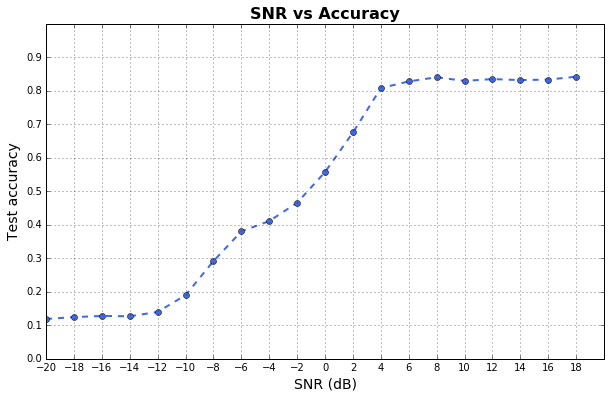

In [7]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./DNN4layer_regtech_l2
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.83  0.00   0.00  0.00  0.00   0.09   0.08   0.0
BPSK   0.00  0.99   0.00  0.00  0.00   0.00   0.01   0.0
CPFSK  0.01  0.01   0.94  0.00  0.00   0.02   0.02   0.0
GFSK   0.02  0.00   0.01  0.95  0.00   0.00   0.01   0.0
PAM4   0.00  0.01   0.00  0.00  0.98   0.01   0.00   0.0
QAM16  0.07  0.00   0.00  0.00  0.00   0.51   0.43   0.0
QAM64  0.01  0.00   0.00  0.00  0.00   0.47   0.52   0.0
QPSK   0.04  0.00   0.00  0.00  0.01   0.03   0.02   0.9


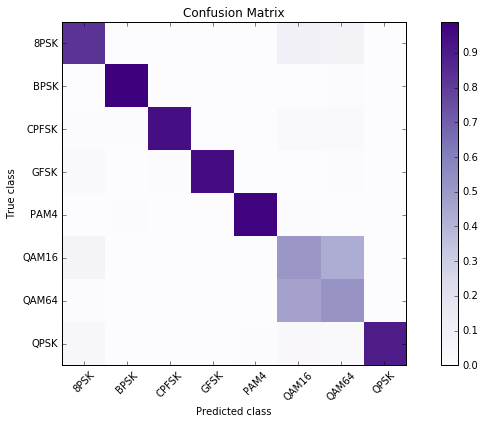

In [8]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_32test_std[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_32_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()